ABSTRACT

BUSINESS PROBLEM

DATA OVERVIEW

EXPLORATORY DATA ANALYSIS

In [186]:
# import relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout

In [187]:
# Read in Amazon stock prices csv file
df = pd.read_csv('daily_adjusted_AMZN.csv')

In [188]:
# Sort by date
df.sort_values('timestamp', inplace=True)

In [189]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
5199,2000-01-03,81.50,89.56,80.00,89.38,89.38,16117600,0.0,1.0
5198,2000-01-04,85.38,91.50,81.75,81.94,81.94,17487400,0.0,1.0
5197,2000-01-05,70.75,75.13,69.63,71.75,71.75,38457400,0.0,1.0
5196,2000-01-06,71.31,72.69,64.00,65.56,65.56,18752000,0.0,1.0
5195,2000-01-07,67.00,70.50,66.19,69.56,69.56,10505400,0.0,1.0


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 5199 to 0
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          5200 non-null   object 
 1   open               5200 non-null   float64
 2   high               5200 non-null   float64
 3   low                5200 non-null   float64
 4   close              5200 non-null   float64
 5   adjusted_close     5200 non-null   float64
 6   volume             5200 non-null   int64  
 7   dividend_amount    5200 non-null   float64
 8   split_coefficient  5200 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 406.2+ KB


In [191]:
# Convert timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

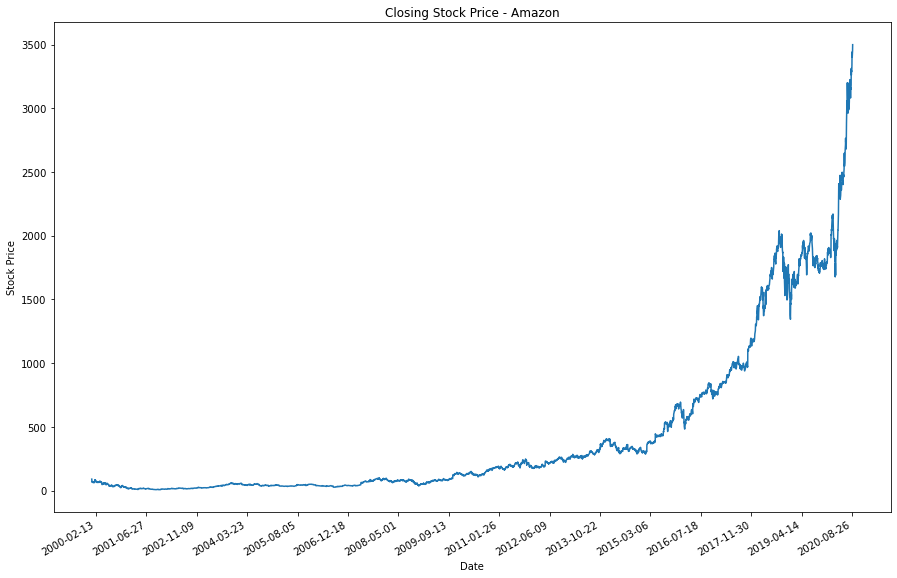

In [192]:
# Plot closing price trend

fig, ax = plt.subplots(figsize= (15,10))

ax.plot(df['timestamp'], df['close'])
ax.set_title('Closing Stock Price - Amazon')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))  # Set the maximum number of ticks
plt.gcf().autofmt_xdate()

In [193]:
# Create new column of average price per day
df['average'] = (df['high'] + df['low'])/2

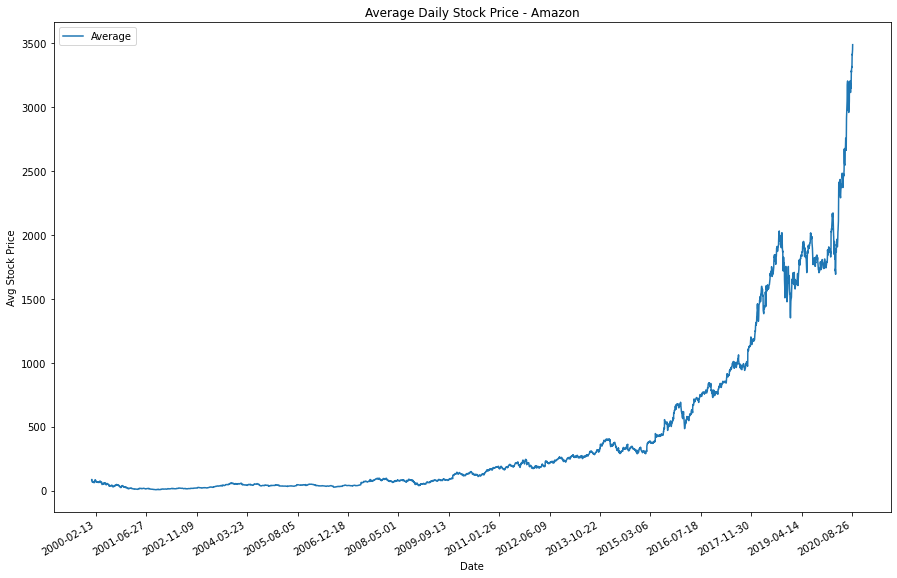

In [194]:
# Plot average price per day
fig, ax = plt.subplots(figsize= (15,10))
ax.plot(df['timestamp'], df['average'], label='Average')
ax.set_title('Average Daily Stock Price - Amazon')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Stock Price')
ax.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))  # Set the maximum number of ticks
plt.gcf().autofmt_xdate()

In [195]:
# Create new columns of rolling average prices for 10 days, 20 days, and 50 days
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['close'].rolling(ma).mean()

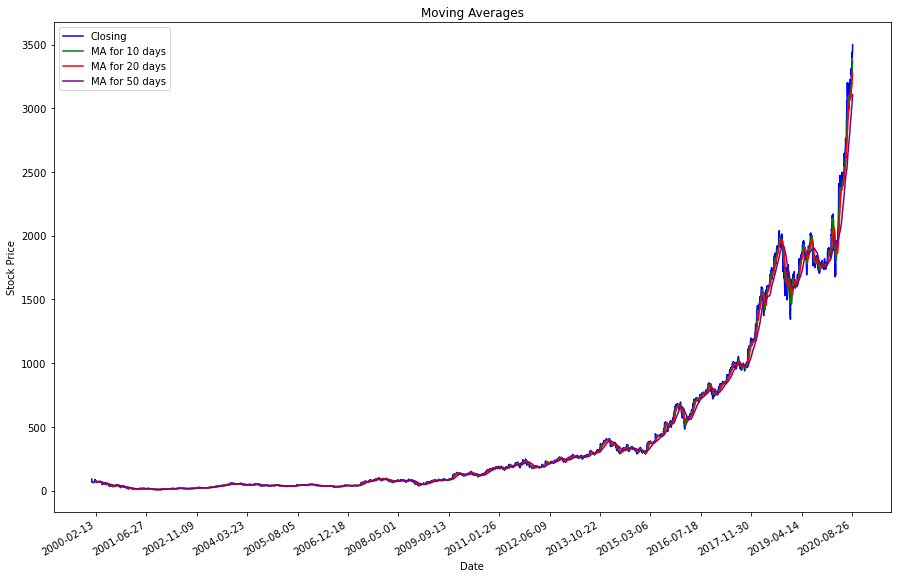

In [196]:
# Plot rolling average prices vs actual closing price
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df['timestamp'], df['close'], label='Closing', color='blue')
ax.plot(df['timestamp'],df['MA for 10 days'], label='MA for 10 days', color='green')
ax.plot(df['timestamp'],df['MA for 20 days'], label='MA for 20 days', color='red')
ax.plot(df['timestamp'],df['MA for 50 days'], label='MA for 50 days', color='purple')
ax.set_title('Moving Averages')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Date')
ax.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))  # Set the maximum number of ticks
plt.gcf().autofmt_xdate()

In [197]:
# Create new column of just the year
df['year'] = df['timestamp'].dt.year

In [198]:
# Create new dataframe of prices after 2018 to get a closer look at the moving averages vs price
af = df.loc[df['year'] > 2018]

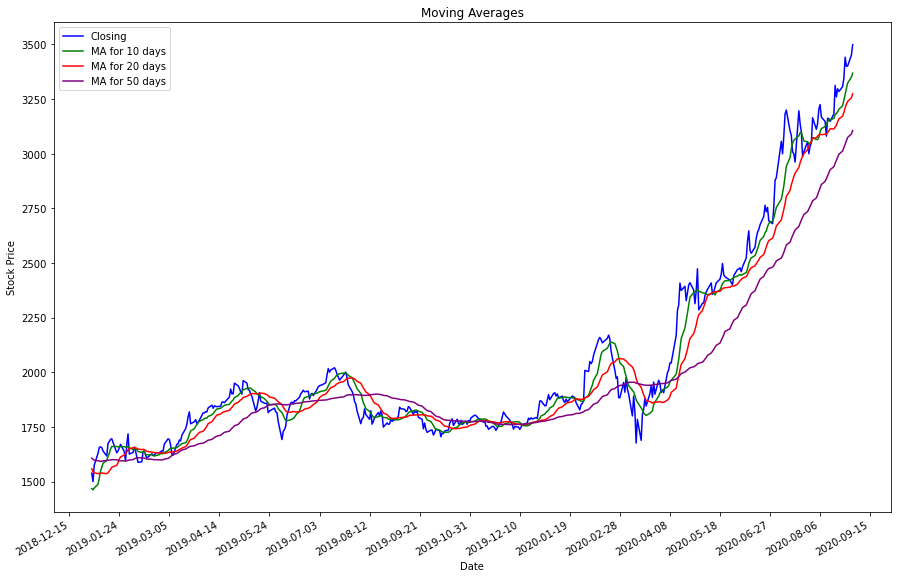

In [199]:
# Plotting the moving averages vs closing price
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(af['timestamp'], af['close'], label='Closing', color='blue')
ax.plot(af['timestamp'],af['MA for 10 days'], label='MA for 10 days', color='green')
ax.plot(af['timestamp'],af['MA for 20 days'], label='MA for 20 days', color='red')
ax.plot(af['timestamp'],af['MA for 50 days'], label='MA for 50 days', color='purple')
ax.set_title('Moving Averages')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Date')
ax.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))  # Set the maximum number of ticks
plt.gcf().autofmt_xdate()

In [200]:
# Create a new dataframe of relevant columns for baseline model
df_main = df[['timestamp', 'close', 'average']]

In [201]:
# Create a 50 day rolling average column
df_main['50day'] = df_main['close'].rolling(50).mean()

<ipython-input-201-efc92c76b392>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['50day'] = df_main['close'].rolling(50).mean()


In [202]:
# Create a 200 day rolling average column
df_main['200day'] = df_main['close'].rolling(200).mean()

<ipython-input-202-9383322f8378>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['200day'] = df_main['close'].rolling(200).mean()


In [203]:
# Create a training set of 80% of the data
train_percentage = 0.8
split_index = int(df.shape[0]*train_percentage)

In [204]:
# Create a dataframe of the 20% testing data
df_main_test = df_main.iloc[split_index :, :]

In [205]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

In [206]:
def calculate_perf_metrics(var):
    '''
      RMSE of the actual closing price compared rolling average specified by var
    '''
    rmse = calculate_rmse(
        np.array(df_main[split_index:]["close"]),
        np.array(df_main[split_index:][var]),
    )

    return rmse

In [207]:
# Calculating the RMSE of the 50 day rolling average model
rmse_sma = calculate_perf_metrics(var='50day')
print(rmse_sma)

135.3946009147816


In [208]:
# Calculating the RMSE of the 200 day rolling average model
calculate_perf_metrics(var='200day')

304.87960308309044

In [209]:
# Creating series variables for date, 50 day, 200 day, close, and average
date = df_main_test['timestamp']
sma_50 = df_main_test['50day']
sma_200 = df_main_test['200day']
close = df_main_test['close']
avg = df_main_test['average']

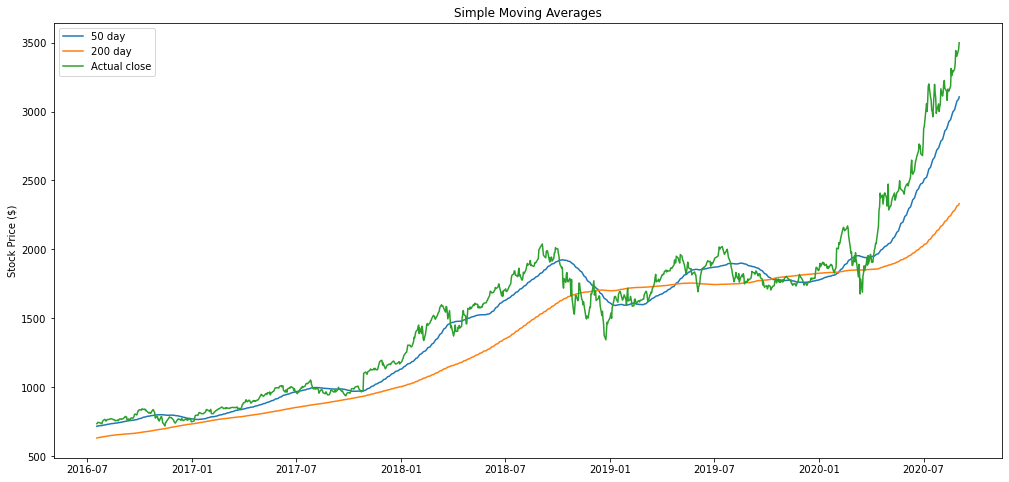

In [222]:
# Plotting the closing value price vs the rolling average predictions on the test data
fig, ax = plt.subplots(figsize= (17,8))
ax.plot(date, sma_50, label='50 day')
ax.plot(date, sma_200, label='200 day')
ax.plot(date, close, label='Actual close')
plt.grid(False)
plt.title('Simple Moving Averages')
plt.axis('tight')
plt.ylabel('Stock Price ($)')
plt.legend()

In [211]:
# Creating numpy arrays for high price, low price, and average price
high_prices = df.loc[:, 'high'].values
low_prices = df.loc[:, 'low'].values
mid_prices = df.loc[:, 'average'].values

In [212]:
# Reshaping the mid price array
mid_prices = mid_prices.reshape(-1, 1)

In [213]:
# Creating a MinMaxScaler object and scaling the mid prices array
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(mid_prices)

In [214]:
scaled_data

array([[0.02266381],
       [0.02319328],
       [0.01910533],
       ...,
       [0.97689854],
       [0.98839619],
       [1.        ]])

In [215]:
# Creating the train test splits based on the split index variable
train = scaled_data[:split_index]
test = scaled_data[split_index-60:, :]

In [216]:
# Creating the training dataset from the scaled data

x_train = []
y_train = []

for i in range(60, len(train)):
    x_train.append(train[i-60:i])
    y_train.append(train[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape, y_train.shape)

# Reshape the data
##x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([[0.02266381],
       [0.02319328],
       [0.01910533],
       [0.01794739],
       [0.01794739],
       [0.01816262],
       [0.01770489],
       [0.01713094],
       [0.01703337],
       [0.01734617],
       [0.01672774],
       [0.0170592 ],
       [0.01712233],
       [0.01621693],
       [0.0185486 ],
       [0.01802774],
       [0.01766902],
       [0.01732896],
       [0.01647664],
       [0.01601031],
       [0.01770633],
       [0.01842233],
       [0.02176845],
       [0.02139969],
       [0.01985864],
       [0.02092475],
       [0.02183015],
       [0.02062916],
       [0.02052155],
       [0.0197582 ],
       [0.01940091],
       [0.01900632],
       [0.01832332],
       [0.0174007 ],
       [0.01692432],
       [0.01791151],
       [0.0179933 ],
       [0.01764319],
       [0.01717686],
       [0.01768337],
       [0.01748966],
       [0.01658426],
       [0.01652973],
       [0.01699607],
       [0.01669187],
       [0.0163145 ],
       [0.01715821],
       [0.01

In [217]:
# Creating an initial LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
4100/4100 [==============================] - 70s 16ms/step - loss: 5.2419e-05
Epoch 2/5
4100/4100 [==============================] - 65s 16ms/step - loss: 2.2608e-05
Epoch 3/5
4100/4100 [==============================] - 66s 16ms/step - loss: 1.2616e-05
Epoch 4/5
4100/4100 [==============================] - 67s 16ms/step - loss: 1.4183e-05
Epoch 5/5
4100/4100 [==============================] - 77s 19ms/step - loss: 1.1080e-05


In [218]:
# Create the data sets x_test and y_test
x_test = []
y_test = []
y_test = mid_prices[split_index:, :]
for i in range(60, len(test)):
    x_test.append(test[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)
##y_test = np.array(y_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

##y_test = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
mse = mean_squared_error(y_test, predictions, squared=False)
print(rmse, mse)

33/33 [==============================] - 2s 24ms/step
99.86528573671984 99.86528573671984


In [224]:
# Creating a function to quickly run LSTM models
def run_LSTM_model(num_epoch, num_neurons_1, num_neurons_2, batch_size):
    ''' Creates a model using these variables:
        num_epoch - number of epochs to fit the model
        num_neurons_1 - number of units for the first level of neural net
        num_neurons_2 - number of units for the second level of neural net
        batch_size - batch size when fitting the model

        Then plots how the model performs 
    '''
    mdl = Sequential()
    mdl.add(LSTM(num_neurons_1, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    mdl.add(LSTM(num_neurons_2, return_sequences=False))
    mdl.add(Dense(25))
    mdl.add(Dense(1))

# Compile the model
    mdl.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
    mdl.fit(x_train, y_train, batch_size=batch_size, epochs=num_epoch)
    preds = mdl.predict(x_test)
    preds = scaler.inverse_transform(preds)

    # Get the root mean squared error (RMSE)
    rmse = mean_squared_error(y_test, preds, squared=False)

    # Getting the coordinates to place text inside the plot
    date_center = date[len(date)/2]
    y_point = max(preds) - 200

    # Plotting the predicted prices vs the average prices
    fig, ax = plt.subplots(figsize=(17,8))
    ax.plot(date, avg, label='Actual Price')
    ax.plot(date, preds, label='Predicted Price')
    ax.text(date_center, y_point, f'RMSE = {rmse}', ha='center', va='center', fontsize=12, color='red')
    plt.grid(False)
    plt.title(f'Actual Price vs Predicted with Batch Size of {batch_size}')
    plt.axis('tight')
    plt.ylabel('Stock Price ($)')
    plt.legend()

    return rmse

Epoch 1/15
820/820 [==============================] - 40s 45ms/step - loss: 2.9609e-05
Epoch 2/15
820/820 [==============================] - 43s 53ms/step - loss: 1.6627e-05
Epoch 3/15
820/820 [==============================] - 42s 51ms/step - loss: 1.0190e-05
Epoch 4/15
820/820 [==============================] - 42s 51ms/step - loss: 9.1341e-06
Epoch 5/15
820/820 [==============================] - 43s 52ms/step - loss: 7.9028e-06
Epoch 6/15
820/820 [==============================] - 43s 52ms/step - loss: 6.9997e-06
Epoch 7/15
820/820 [==============================] - 43s 52ms/step - loss: 8.3481e-06
Epoch 8/15
820/820 [==============================] - 44s 53ms/step - loss: 5.9810e-06
Epoch 9/15
820/820 [==============================] - 43s 52ms/step - loss: 6.4828e-06
Epoch 10/15
820/820 [==============================] - 47s 58ms/step - loss: 5.6832e-06
Epoch 11/15
820/820 [==============================] - 48s 59ms/step - loss: 4.6725e-06
Epoch 12/15
820/820 [====================

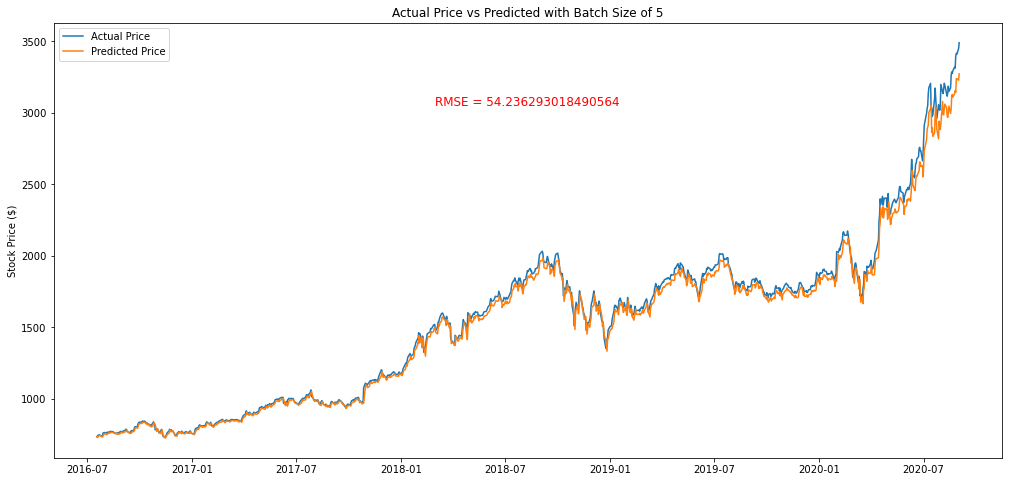

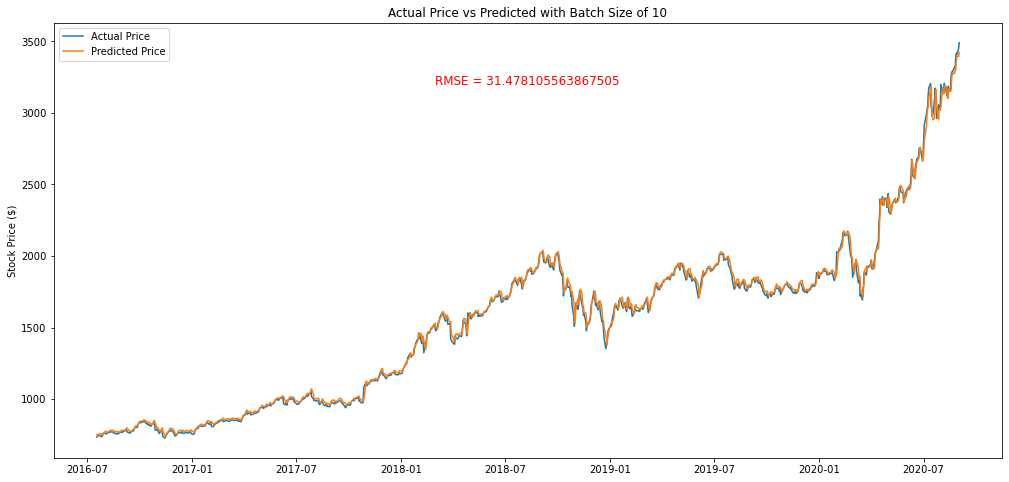

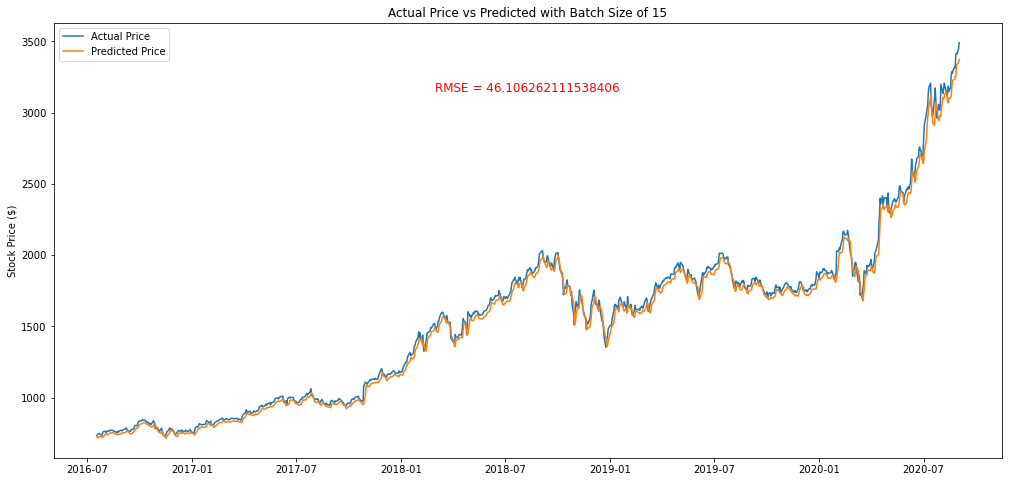

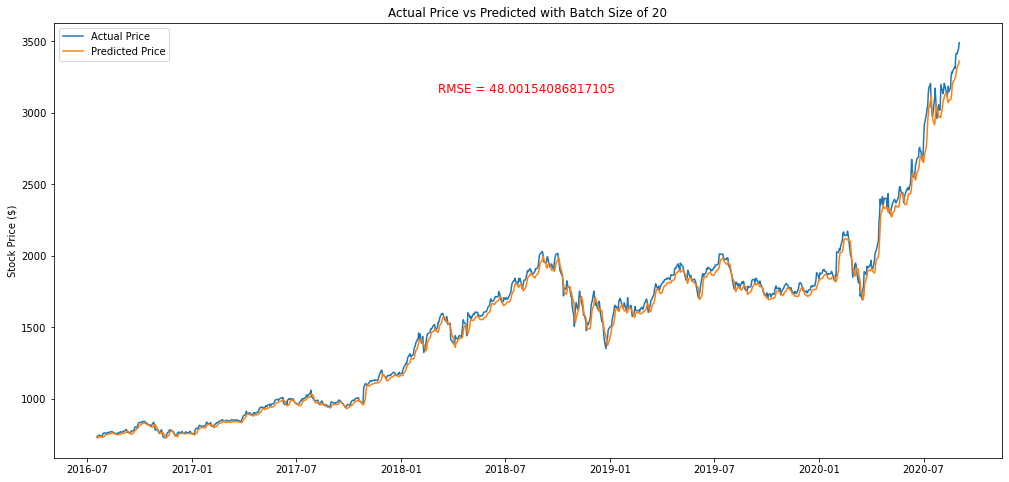

In [225]:
# Running LSTM models for the 4 batch sizes
batch_list = [5, 10, 15, 20]

for i in batch_list:
    run_LSTM_model(15, 168, 63, i)